In [30]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU,Dropout
import librosa

In [31]:
def df_to_vector_array(df,
                       sampling_rate = 48000,
                       hop_length = 1024,
                       n_fft = 65536):
    ample_array = np.array(df.loc[:,'ample'])
    n_fft = n_fft

    # フレームごとのシフトサイズ（一般的には `n_fft // 4` など）
    hop_length = hop_length

    # メルスペクトログラムの生成
    mel_spectrogram = librosa.feature.melspectrogram(y=ample_array, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length)

    # MFCC の計算 (13係数で設定)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrogram), n_mfcc=13)

    return mfccs

    
    
    
    

In [32]:
sampling_rate = 48000
df = pd.read_csv('../data/20240509/raw/mic_normal0.csv')
mfccs = df_to_vector_array(df, sampling_rate = sampling_rate)

In [33]:
mfccs.shape

(13, 2807)

In [34]:
training_data = []
x_train = []
y_train = []
data_frames = []

for i in range(7):
    if(i == 0 or i == 1 or i == 3 or i == 4 or i == 5 or i == 7):
        continue
    path_to_mfcc_coord = f'../data/20240509/processed/mfcc_coordinate{i}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames.append(df)
    
combined_df = pd.concat(data_frames, ignore_index=True)

y_columns_to_use = [f'mfcc_{i}' for i in range(13)]

y_train = combined_df[y_columns_to_use].values

x_columns_to_use = ['x','y']
x_train = combined_df[x_columns_to_use].values

training_data = []
data_frames_abnormal = []

for i in range(2):
    path_to_mfcc_coord = f'../data/20240509/processed/abnormal_mfcc_coordinate{i}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames_abnormal.append(df)
    
combined_df = pd.concat(data_frames_abnormal, ignore_index=True)

y_columns_to_use = [f'mfcc_{i}' for i in range(13)]

y_test_abnormal = combined_df[y_columns_to_use].values

x_columns_to_use = ['x','y']
x_test_abnormal = combined_df[x_columns_to_use].values

data_frames_normal = []

for i in range(2):
    path_to_mfcc_coord = f'../data/20240509/processed/normal_mfcc_coordinate{i*4+3}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames_normal.append(df)
    
combined_df = pd.concat(data_frames_normal, ignore_index=True)

y_columns_to_use = [f'mfcc_{i}' for i in range(13)]

y_test_normal = combined_df[y_columns_to_use].values

x_columns_to_use = ['x','y']
x_test_normal = combined_df[x_columns_to_use].values


In [35]:
class Decoder(Model):
    def __init__(self, layer_num, input_dim=2, output_dim=13,dropout_ratio = 0.1):
        super(Decoder, self).__init__()
        self.layer_num = layer_num
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.hidden_layers = []
        for i in range(layer_num):
            nodes = 2 ** (i + 1)
            self.hidden_layers.append(Dense(nodes, activation='linear'))
            self.hidden_layers.append(BatchNormalization())
            self.hidden_layers.append(LeakyReLU(alpha=0.01))
            self.hidden_layers.append(Dropout(rate = dropout_ratio))

        self.dense_output = Dense(output_dim, activation='sigmoid')

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.dense_output(x)
        return x



In [36]:
class SAMModel(tf.keras.models.Model):
    def __init__(self, base_model, *args, rho=0.05, **kwargs):
        super().__init__( *args, **kwargs)
        self.rho = tf.constant(rho, dtype=tf.float32)
        self.base_model = base_model  

    def call(self, inputs):
        return self.base_model(inputs)  

    def train_step(self,data):
        x, y = data

        # 1st step
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        norm = tf.linalg.global_norm(gradients)
        scale = self.rho / (norm + 1e-12)
        e_w_list = []
        for v, grad in zip(trainable_vars, gradients):
            e_w = grad * scale
            v.assign_add(e_w)
            e_w_list.append(e_w)

        # 2nd step
        with tf.GradientTape() as tape:
            y_pred_adv = self(x, training=True)
            loss_adv = self.compiled_loss(y, y_pred_adv, regularization_losses=self.losses)
        gradients_adv = tape.gradient(loss_adv, trainable_vars)
        for v, e_w in zip(trainable_vars, e_w_list):
            v.assign_sub(e_w)

        # optimize
        self.optimizer.apply_gradients(zip(gradients_adv, trainable_vars))

        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
inputs = tf.keras.layers.Input(shape=(2,))
base_model = Decoder(layer_num=6, input_dim=2, output_dim=13,dropout_ratio = 0.2)
model = SAMModel(base_model = base_model, rho=0.05)
model.compile(loss="mse", optimizer="Adam", metrics=["accuracy"])
model.summary()

c:\Users\kenta\anaconda3\envs\sound_coordinate\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sam_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_2 (Decoder)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [37]:
def min_max_scaler(arr,min_val,max_val):
    arr = (arr-min_val)/(max_val-min_val)   
    arr = np.where(arr < 0, 0, arr)
    arr = np.where(arr > 1, 1, arr)
    return arr



std_weight = 3
for idx in range(y_train.shape[1]):
    mean_val = y_train[:,idx].mean()
    std_val = y_train[:,idx].std()
    max_val = mean_val + std_weight*std_val
    min_val = mean_val - std_weight*std_val
    y_train[:,idx] = min_max_scaler(y_train[:,idx], min_val, max_val)
    y_test_abnormal[:,idx] = min_max_scaler(y_test_abnormal[:,idx], min_val, max_val)
    y_test_normal[:,idx] = min_max_scaler(y_test_normal[:,idx], min_val, max_val)

In [38]:
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100


c:\Users\kenta\anaconda3\envs\sound_coordinate\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:603: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight)`.
  warnings.warn(
c:\Users\kenta\anaconda3\envs\sound_coordinate\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:578: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2162 - loss: 0.4994 - val_accuracy: 0.0000e+00 - val_loss: 0.0293
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2310 - loss: 0.4970 - val_accuracy: 0.1138 - val_loss: 0.0329
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2275 - loss: 0.5024 - val_accuracy: 0.0000e+00 - val_loss: 0.0342
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2262 - loss: 0.4959 - val_accuracy: 0.0122 - val_loss: 0.0389
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2861 - loss: 0.5018 - val_accuracy: 0.0000e+00 - val_loss: 0.0370
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 0.5004 - val_accuracy: 0.0000e+00 - val_loss: 0.0369
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2780 - loss: 0.5024 - val_accuracy: 0.0000e+00 - val_loss: 0.0377
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2864 - loss: 0.5021 - val_accuracy: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


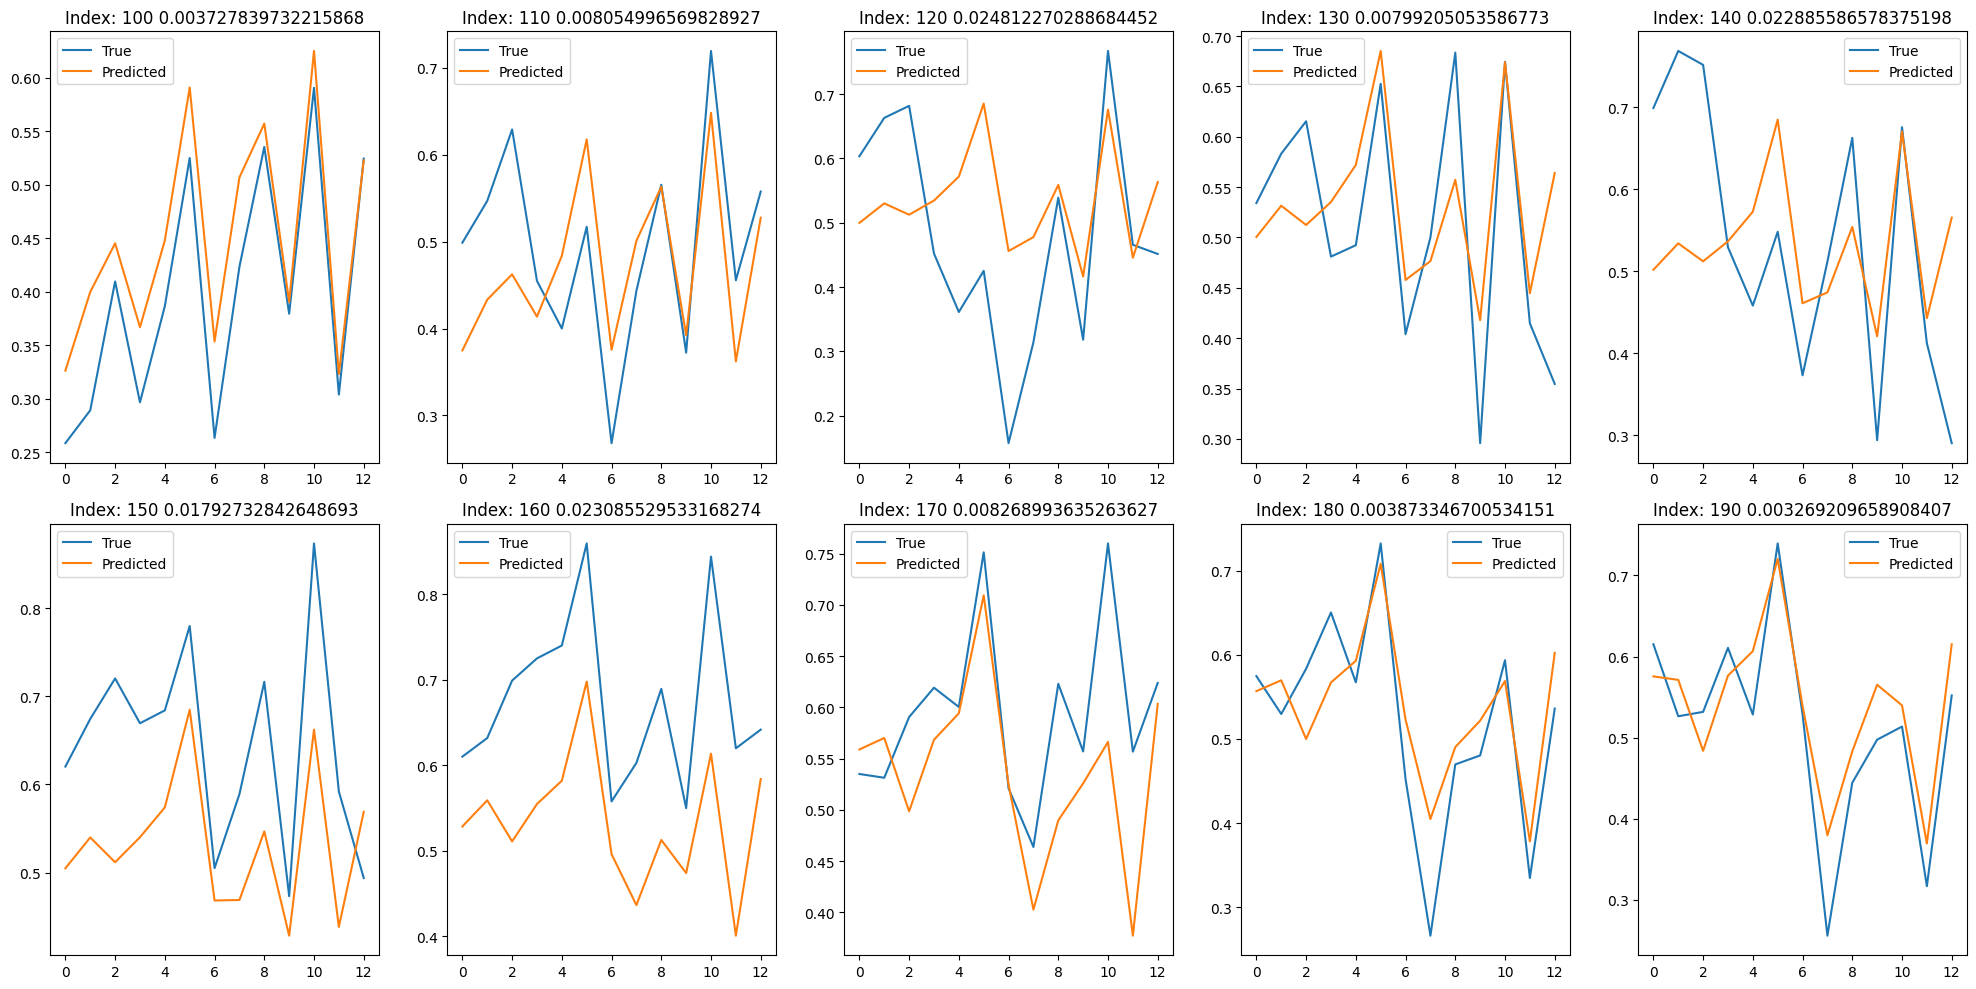

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error


# Configuration
start_index = 100  # Starting point for the graphs
num_graphs = 10  # Number of subplots to generate
index_step = 10  # Index increment between graphs

# Set up the figure and the subplots grid
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # Adjust rows/columns as needed
axs = axs.flatten()  # Flattening to easily index

# Plot each graph in a separate subplot
for i in range(num_graphs):
    current_index = start_index + i * index_step
    x = np.expand_dims(x_test_normal[current_index], axis=0)  # Adjust input shape if necessary
    y_predicted = model.predict(x)
    y_predicted = np.squeeze(y_predicted)
    
    # 平均二乗誤差を計算
    mse = mean_squared_error(y_predicted, y_test_normal[current_index])
    
    # Plot original vs predicted in the current subplot
    axs[i].plot(y_test_normal[current_index].T, label='True')
    axs[i].plot(y_predicted.T, label='Predicted')
    
    axs[i].set_title(f'Index: {current_index} {mse}')
    axs[i].legend()

# Adjust the layout to prevent overlap and show the plot
plt.tight_layout()
plt.show()


In [40]:
y_predicted_normal = model.predict(x_test_normal)
y_predicted_abnormal = model.predict(x_test_abnormal)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [41]:
print(y_predicted_normal.shape, y_test_normal.shape)

(2456, 13) (2456, 13)


In [18]:
mses_normal = []
for i in range(y_predicted_normal.shape[0]):
    mse = mean_squared_error(y_predicted_normal[i],y_test_normal[i])
    mses_normal.append(mse)

In [19]:
print(y_predicted_abnormal.shape, y_test_abnormal.shape)

(2457, 13) (2457, 13)


In [20]:
mses_abnormal = []
for i in range(y_predicted_abnormal.shape[0]):
    mse = mean_squared_error(y_predicted_abnormal[i],y_test_abnormal[i])
    mses_abnormal.append(mse)

In [21]:
mses_abnormal = np.array(mses_abnormal)
mses_abnormal.shape

(2457,)

<Axes: >

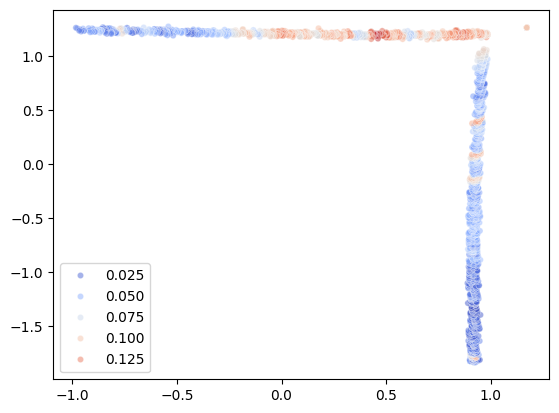

In [22]:
import seaborn as sns
sns.scatterplot(
    x=x_test_abnormal[:,0],
    y=x_test_abnormal[:,1],
    hue=mses_abnormal,
    s=20,
    alpha=0.5,
    palette='coolwarm'
)

<Axes: >

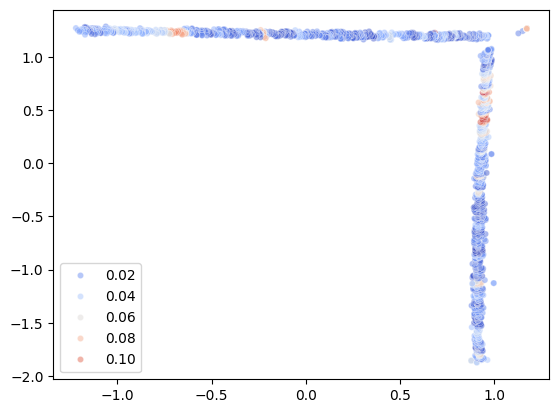

In [23]:
import seaborn as sns
sns.scatterplot(
    x=x_test_normal[:,0],
    y=x_test_normal[:,1],
    hue=mses_normal,
    s=20,
    alpha=0.5,
    palette='coolwarm'
)

<Axes: xlabel='mse', ylabel='Count'>

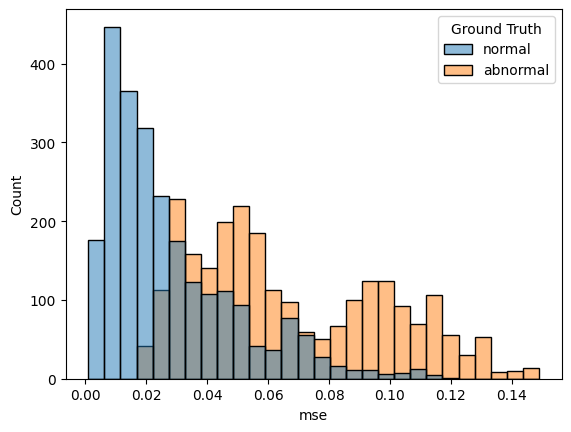

In [27]:
plt_df_normal = pd.DataFrame({'mse':mses_normal})
plt_df_normal['Ground Truth'] = 'normal'
plt_df_abnormal = pd.DataFrame({'mse':mses_abnormal})
plt_df_abnormal['Ground Truth'] = 'abnormal'

plt_df = pd.concat([plt_df_normal, plt_df_abnormal], ignore_index=True)
sns.histplot(
    data=plt_df,
    x='mse',
    hue='Ground Truth'
)


In [28]:
plt_df['Label'] = plt_df['Ground Truth']=='abnormal'

In [29]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

# Min-Maxスケーリング
scaler = MinMaxScaler()
y_scores_scaled = scaler.fit_transform(np.array(plt_df['mse']).reshape(-1, 1)).flatten()

# AUC計算
auc = roc_auc_score(plt_df['Label'], y_scores_scaled)
# 結果の出力
print(f"AUC: {auc:.4f}")


AUC: 0.8615
